# <span style="color:black"> Data Science Salaries </span>
Please see the corresponding [kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) link for the details.

# <span style="color:green"> DATA </span>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14})

import pycountry
import seaborn as sns

In [4]:
data = pd.read_csv("diabetes_prediction.csv")
data.head(4)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0


# <span style="color:green"> DATA ANALYSIS </span>

In [5]:
print(f"total data shape: {data.shape}")

def unique_features(data):
    nums = []# unique possibilities for each feature
    for feature in data.columns:
        num = len(data.loc[:,feature].unique())
        nums.append(num)
        print(f"feature {feature:20s}: unique values = {num}")
        
unique_features(data)

total data shape: (100000, 9)
feature gender              : unique values = 3
feature age                 : unique values = 102
feature hypertension        : unique values = 2
feature heart_disease       : unique values = 2
feature smoking_history     : unique values = 6
feature bmi                 : unique values = 4247
feature HbA1c_level         : unique values = 18
feature blood_glucose_level : unique values = 18
feature diabetes            : unique values = 2


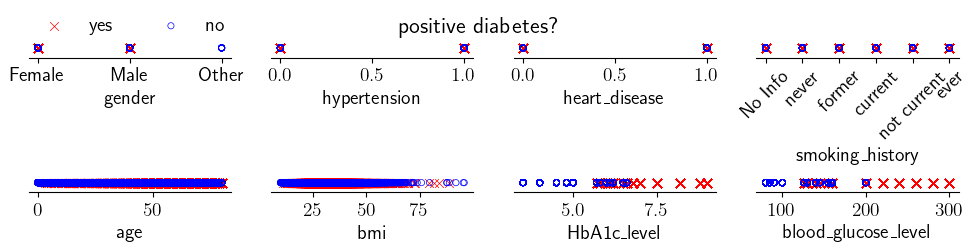

In [74]:
features = ['gender','hypertension','heart_disease','smoking_history',
            'age','bmi','HbA1c_level','blood_glucose_level']

fig, ax = plt.subplots(2, 4, figsize=(12, 2))
fig.subplots_adjust(hspace=6)

ax = ax.flatten()  # Flatten the ax array to access each subplot individually
yes = data.loc[:,'diabetes'] == 1
no = data.loc[:,'diabetes'] == 0
dummy_vec = np.ones(data.shape[0])
for i in range(len(ax)):
    ax[i].scatter(data.loc[yes,features[i]],dummy_vec[yes],marker='x',color='r',s=40,linewidth=0.5,label='yes')
    ax[i].scatter(data.loc[no,features[i]],dummy_vec[no],marker='o',edgecolors='b',facecolors='none',s=20,linewidth=0.5,label='no')
    ax[i].set_xlabel(features[i])
    ax[i].get_yaxis().set_ticks([])
    ax[i].set_ylim(0,2)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    if i == 0:
        ax[i].legend(frameon=False,ncol=2,loc='upper center', bbox_to_anchor=(0, 1, 1, 2))
    if features[i] == 'smoking_history':
        value_counts = data.value_counts('smoking_history')
        xticks = range(len(value_counts))
        xticklabels = value_counts.index.values
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xticklabels,rotation=45)

fig.suptitle('positive diabetes?', fontsize=16)
plt.show()

**Note:** The above figures for categorical features can be quite misleading. Below, we analyze what percentage of the postive cases belong to a specific category (e.g., male or female?)

### **gender**

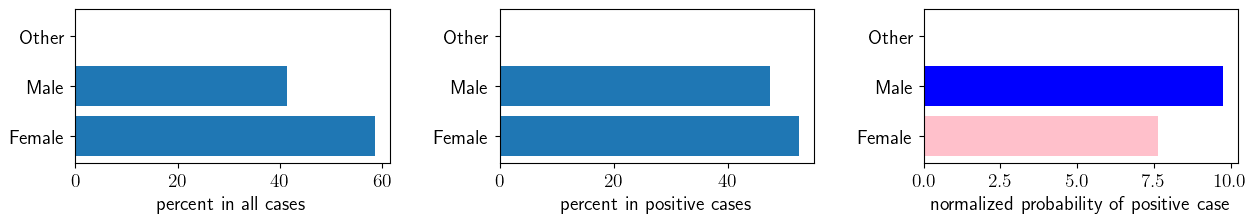

In [181]:
def barplots(feature):
    feature_counts = data.value_counts(feature).sort_index()
    fig, ax = plt.subplots(1, 3, figsize=(15, 2))
    fig.subplots_adjust(wspace=0.35)
    ax = ax.flatten()
    ax[0].barh(feature_counts.index,feature_counts.values/data.shape[0]*100)
    ax[0].set_xlabel('percent in all cases')

    diabetes_by_feature = data.groupby(feature, as_index=True)['diabetes'].sum()
    total_positive_cases = len(data[data['diabetes']==1])
    ax[1].barh(diabetes_by_feature.index,diabetes_by_feature.values/total_positive_cases*100)
    ax[1].set_xlabel('percent in positive cases')

    return diabetes_by_feature, feature_counts, ax, fig

diabetes_by_feature, feature_counts, ax, fig = barplots('gender')
normalized_probability = [diabetes_by_feature['Female']/feature_counts['Female'],
                          diabetes_by_feature['Male']/feature_counts['Male'],
                          diabetes_by_feature['Other']/feature_counts['Other']]
ax[2].barh(['Female','Male','Other'],np.array(normalized_probability)*100,color=['pink', 'blue', 'black'])
ax[2].set_xlabel('normalized probability of positive case')

plt.show()

### **hypertension**

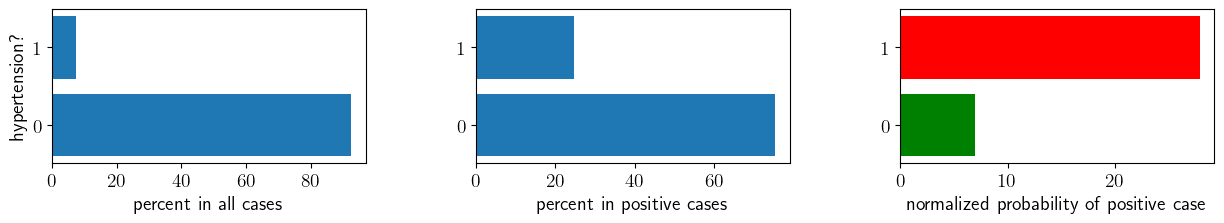

In [182]:
diabetes_by_feature, feature_counts, ax, fig = barplots('hypertension')
normalized_probability = [diabetes_by_feature[0]/feature_counts[0],
                          diabetes_by_feature[1]/feature_counts[1]]
ax[2].barh([0,1],np.array(normalized_probability)*100,color=['green','red'])
ax[2].set_xlabel('normalized probability of positive case')
ax[0].set_ylabel('hypertension?')

plt.show()

### **heart disease**

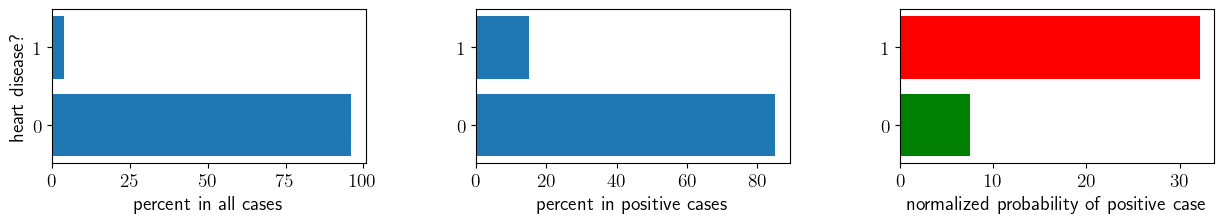

In [183]:
diabetes_by_feature, feature_counts, ax, fig = barplots('heart_disease')
normalized_probability = [diabetes_by_feature[0]/feature_counts[0],
                          diabetes_by_feature[1]/feature_counts[1]]
ax[2].barh([0,1],np.array(normalized_probability)*100,color=['green','red'])
ax[2].set_xlabel('normalized probability of positive case')
ax[0].set_ylabel('heart disease?')

plt.show()

### **smoking**

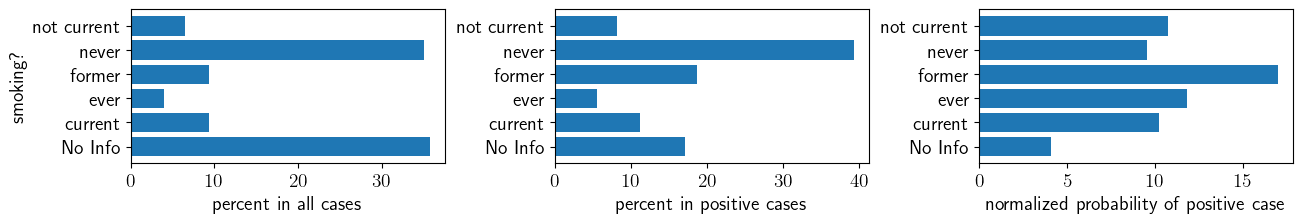

In [187]:
diabetes_by_feature, feature_counts, ax, fig = barplots('smoking_history')

normalized_probability = []
for i in feature_counts.index:
    normalized_probability.append(diabetes_by_feature[i]/feature_counts[i])

ax[2].barh(feature_counts.index,np.array(normalized_probability)*100)
ax[2].set_xlabel('normalized probability of positive case')
ax[0].set_ylabel('smoking?')

plt.show()

### **age**

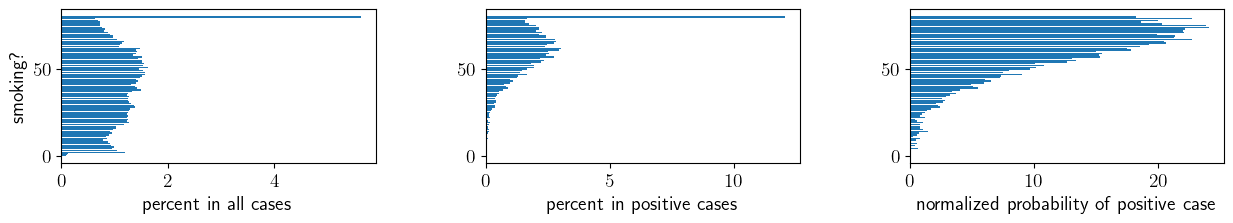

In [227]:
diabetes_by_feature, feature_counts, ax, fig = barplots('age')

normalized_probability = []
for i in feature_counts.index:
    normalized_probability.append(diabetes_by_feature[i]/feature_counts[i])

ax[2].barh(feature_counts.index,np.array(normalized_probability)*100)
ax[2].set_xlabel('normalized probability of positive case')
ax[0].set_ylabel('smoking?')

plt.show()


## Data Analysis Conclusion
It is evident from above analyses that **hypertension**, **heart disease**, **age**, **HbA1c level**, and **blood glucose level** strongly contribute to the probability of a positive diabetes.

## One-hot encoding

In [232]:
cat_features = ['gender','smoking_history']
print(f"The multiclass categorical features are:\n{cat_features}")
dataOHE = pd.get_dummies(data = data, prefix = cat_features, columns = cat_features)

features = [x for x in dataOHE.columns if x != 'diabetes'] ## Removing our target variable
print(f"total number of features after one-hot encoding: {len(features)}")

The multiclass categorical features are:
['gender', 'smoking_history']
total number of features after one-hot encoding: 15


## Correllation

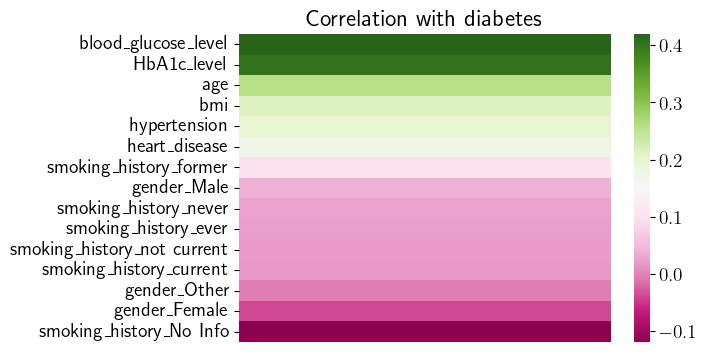

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0
5,20.0,0,0,27.32,6.6,85,0,1,0,0,0,0,0,0,1,0
6,44.0,0,0,19.31,6.5,200,1,1,0,0,0,0,0,0,1,0
7,79.0,0,0,23.86,5.7,85,0,1,0,0,1,0,0,0,0,0
8,42.0,0,0,33.64,4.8,145,0,0,1,0,0,0,0,0,1,0
9,32.0,0,0,27.32,5.0,100,0,1,0,0,0,0,0,0,1,0


In [237]:
corr = dataOHE.corr().loc[:,'diabetes']
corr = corr.sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.heatmap(corr.iloc[1:].to_frame(), cmap="PiYG", xticklabels=False, yticklabels=True)
plt.title('Correlation with diabetes')
plt.show()

dataOHE.head(10)

# <span style="color:green"> MACHINE LEARNING </span>

## Split the data using Scikit-learn

In [58]:
X_train, X_dev, y_train, y_dev = train_test_split(dataOHE[features],dataOHE['diabetes'],train_size=0.8, random_state=1)

X_train = X_train.to_numpy()
X_dev   = X_dev.to_numpy()

y_train = y_train.to_numpy().reshape((-1,1))
y_dev   = y_dev.to_numpy().reshape((-1,1))

print(f"X_train.shape = {X_train.shape}, X_dev.shape = {X_dev.shape}")
print(f"y_train.shape = {y_train.shape}, y_dev.shape = {y_dev.shape}")

X_train.shape = (3004, 32), X_dev.shape = (751, 32)
y_train.shape = (3004, 1), y_dev.shape = (751, 1)
